# Causal Inference in Python
This notebook is an exploration of causal inference in python using the famous Lalonde dataset.

Causal inference is a technique to estimate the effect of one variable onto another, given the presence of other influencing variables (confonding factors) that we try to keep 'controlled'.
The study looked at the effectiveness of a job training program (the treatment) on the real earnings of an individual, a couple years after completion of the program.

The data consists of a number of demographic variables (age, race, academic background, and previous real earnings), as well as a treatment indicator, and the real earnings in the year 1978 (the response).

Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In this notebook we'll be using the tools provided by Laurence Wong in the Package CausalInference. Comments on what each function does come from the very good package documentation: http://laurence-wong.com/software/

This package relies heavily on Rubin causal model, and so will this analysis https://en.wikipedia.org/wiki/Rubin_causal_model

The reason why several models exist is that it is impossible to observe the causal effect on a single unit, and so assumptions must be made to estimate the missing counterfactuals. We'll explain what all that means in this post.

In [2]:
# https://pypi.org/project/CausalInference/
from causalinference import CausalModel

In [3]:
lalonde = pd.read_csv('C:/Users/moham/Desktop/Python/PSM/lalonde.csv', index_col=0)
lalonde.head()

,treat,age,educ,race,married,nodegree,re74,re75,re78,black,hispan
NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460,1,0
NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940,0,1
NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500,1,0
NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460,1,0
NSW5,1,33,8,black,0,1,0.0,0.0,289.7899,1,0


In [4]:
# let's have an overview of the data
lalonde.describe().T

,count,mean,std,min,25%,50%,75%,max
treat,614.0,0.301303,0.459198,0.0,0.000000,0.0000,1.00000,1.00
age,614.0,27.363192,9.881187,16.0,20.000000,25.0000,32.00000,55.00
educ,614.0,10.268730,2.628325,0.0,9.000000,11.0000,12.00000,18.00
married,614.0,0.415309,0.493177,0.0,0.000000,0.0000,1.00000,1.00
nodegree,614.0,0.630293,0.483119,0.0,0.000000,1.0000,1.00000,1.00
re74,614.0,4557.546569,6477.964479,0.0,0.000000,1042.3300,7888.49825,35040.07
re75,614.0,2184.938207,3295.679043,0.0,0.000000,601.5484,3248.98750,25142.24
re78,614.0,6792.834483,7470.730792,0.0,238.283425,4759.0185,10893.59250,60307.93
black,614.0,0.395765,0.489413,0.0,0.000000,0.0000,1.00000,1.00
hispan,614.0,0.117264,0.321997,0.0,0.000000,0.0000,0.00000,1.00


Here is the raw difference in earning between the control group and the treated group:

In [5]:
lalonde.groupby('treat')['re78'].agg(['median','mean'])

,median,mean
treat,,
0,4975.505,6984.169742
1,4232.309,6349.143530


The control group has higher earning that the treatment group - does this mean the treatment had a negative impact?

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: re78, dtype: object

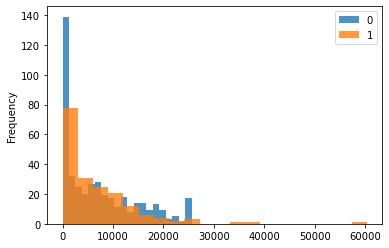

In [6]:
lalonde.groupby('treat')['re78'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: re75, dtype: object

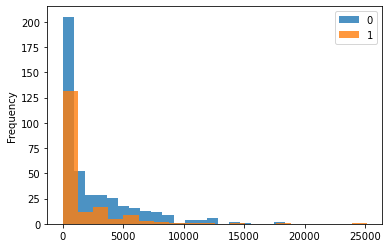

In [7]:
lalonde.groupby('treat')['re75'].plot(kind='hist', bins=20, alpha= 0.8, legend=True)

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

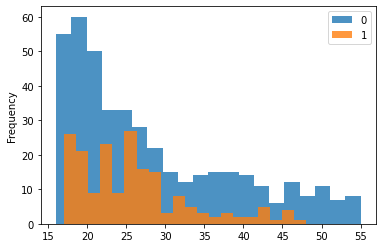

In [8]:
lalonde.groupby('treat')['age'].plot(kind= 'hist', bins= 20, alpha= 0.8, legend= True)

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: educ, dtype: object

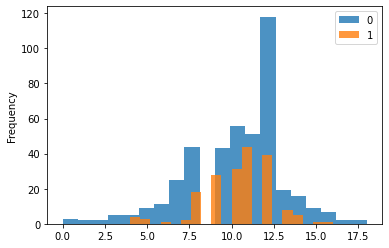

In [9]:
lalonde.groupby('treat')['educ'].plot(kind= 'hist', bins=20, alpha= 0.8, legend= True)

# notation, aims and assumptions
Notations.

Y represents the response, here is is 1978 earnings ('re78')
D represents the treatment: the job training program ('treat')
X represents the confounding variables, here it likely is age, education, race and marital status. X is also called a covariate or the counter factual.
Aims. What we want to know here is the Average Treatment Effect (ATE):
Δ=E[Y1−Y0]
 
However, as we saw, if we try to estimate this quantity from the row observational distribution, we get:
Δraw=E[Y|D=1]−E[Y|D=0]=E[Y1|D=1]−E[Y0|D=0]≠Δ=E[Y1−Y0]
because:
E[Yi|D=i]≠E[Yi]
 
General problem. If we believe that age, education, race, and marital status all have a likely influence on earnings Y, we need a way to disentangle the effect of D on Y from the perturbative effect of X on Y.

Assumptions. The Causalinference package is based on a typical assumption called unconfoundedness or ignorability:
(Y(0),Y(1))⊥D|X
 
Indeed we saw that the treatment assignment is probably not independent of each subject's potential outcomes, e.g. poorer people are more represented in the treatment group than in the control group.

However the treatment is assumed to be unconfounded in the sense that the dependence between the treatment assignment and the outcomes is only through something we observe, namely the covariates X.

What this means is that if we control for X, i.e. look across people with similar levels of X, then the difference between treated and control should be attributable to the treatment itself, just as a randomized experiment would be.

This is the assumption, and if it doesn't hold our results could be completely wrong.

Simple approach
The simplest type of model we can use is a linear model:

Y0=α+βX+ϵ
 
Y1=Y0+γD
 
If this is accurate, fitting the following model to the data using linear regression will give us an estimate of the Average Treatment Effect (ATE):
Y=α+βX+γD
 
ϵ  is called a residual and represents the noise

In [10]:
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

In [11]:
# we use the CausalModel method from the causalinference package

Y=lalonde['re78'].values
D=lalonde['treat'].values
X=lalonde[covariates].values

In [12]:
causal= CausalModel(Y, D, X)

In [13]:
causal.est_via_ols(adj = 1)
#adj: int (0, 1, or 2) Indicates how covariate adjustments are to be performed. 
#Set adj = 0 to not include any covariates.  
#Set adj = 1 to include treatment indicator D and covariates X separately. 
#Set adj = 2 to additionally include interaction terms between D and X. Defaults to 2.

C:\Users\moham\anaconda3\lib\site-packages\causalinference\estimators\ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


In [14]:
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1548.244    734.521      2.108      0.035    108.584   2987.904



__This model predicts that the Average Treatment Effect (ATE, the job training) is $1548 extra annual earnings. This is very different from our previous raw results predicting that the job training had negative effects on earnings!__ 

Assuming that our model accurately describes the counterfactual X, CausalModel provides the 95% confidence interval. What this means is that, if we were to repeat this treatment experiment, in 95% of the cases the Average Treatment Effect would be within that interval. That doesn't mean that the true value is within that interval.

Based on the assumption that the residuals are normally distributed, the 95% confidence interval is calculated as:
AVG±1.96∗STD/√n
 
In practice, as the confidence interval is very large, my interpretation is that the experiment should have had more people if a better estimate of the extra earnings was desired. Ways to control the standard deviation could also be explored.

Overall, assuming that we controlled for all the effects and did it well, it seems that the job training had a positive effect on earnings. Indeed, although the standard deviation is very large, the p value of 0.035 rejects the null hypothesis (no effect) with a confidence level of 97.5%. However, the truth is that we don't know if we modelled the counterfactual well, and this could change everything... As we will see later, estimators such as the Ordinary Least Square (OLS) estimator can behave poorly when there is not enough covariate overlap, and that's because the estimator needs to extrapolate too much from one group to another.

A more structured approach as we will see below can allow us to increase our confidence that the covariants are well controlled for. We will see many steps, but one simple idea is the technique of matching: the idea is to find for each sample which received the treatment a similar sample in the control group, and to directly compare these values.

# Structure for a more complete approach
Pre-processing phase:

_1_.assess covariate balance 

_2_.estimate propensity score 

_3_.trim sample 

_4_.stratify sample 

__Estimation phase:__

_1_.blocking estimator or/and

_2_.matching estimator

# Pre-processing phase

In the pre-processing phase, the data is inspected and manipulated to allow credible analysis to be conducted on it.

As we discussed in the previous section, one key method for disantangling the treatment effect from the covariant effects is the matching technique. In this technique we compare subjects that have similar covariate values (i.e. same age, race, income etc). However, our ability to compare such pairs depends heavily on the degree of overlap of the covariates between the treatment and control group. This is called covariate balance.

Said otherwise, to control the effect of education, one way is to look at people in the tested group and in the non-tested group that all have the same level of education, say a bachelor degree. However, if nobody in the test group has a bachelor degree while many do in the non-test group, this procedure is impossible.

__(1) assess covariate balance__ to assess whether how easily people can be matched. If there is too much unbalance, direct matching will rarely be possible, and we may need to use more complex techniques, if at all possible.

In [16]:
lalonde.columns

Index(['treat', 'age', 'educ', 'race', 'married', 'nodegree', 're74', 're75',
       're78', 'black', 'hispan'],
      dtype='object')

In [17]:
print(causal.summary_stats)


Summary Statistics

                       Controls (N_c=429)         Treated (N_t=185)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     6984.170     7294.162     6349.144     7867.402     -635.026

                       Controls (N_c=429)         Treated (N_t=185)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       28.030       10.787       25.816        7.155       -0.242
             X1       10.235        2.855       10.346        2.011        0.045
             X2        0.203        0.403        0.843        0.365        1.668
             X3        0.142        0.350        0.059        0.237       -0.277
             X4        0.513        0.500        0.189        0.393       -0.719
      

__Raw-diff__ is the raw difference between the means of the control and treatment groups.

As we saw previously, the treated group (trained) is earning $635 less than the control group, which is surprising.

__Nor-diff__ in this package is Imbens and Rubin's normalized differences (2015) in average covariates, defined as:
mean(Xk,t)−mean(Xk,c)/sqrt[sqr(sk,t)+sqr(sk,c)]
 
Here mean(Xk,t)  and  (sk,t)  are the sample mean and sample standard deviation of the kth covariate of the treatment group, and mean(Xk,c)  and  (sk,c)  are the analogous statistics for the control group.

The aim here is to assess the overlap between the control and treatment groups. It can be seen that X2, X4, and X6 (black, married, revenue in 1974) have a large normalized difference, beyond 0.5. This can be interpreted as an imbalance. Concretely, there are way more black people, less married people and lower income in 1974 in the treatment group than in the control group.

The impact of imbalance is to make the matching technique harder to apply. We'll see later how we can try to correct for it (however, ideally the study would be more balanced!).

__(2) Propensity Score__ - the probability of receiving the treatment, conditional on the covariates.

Propensity is useful for assessing and improving covariate balance. Indeed a theorem by Rosenbaum and Rubin in 1983, proves that, for subjects that share the same propensity score (even if their covariate vectors are different), the difference between the treated and the control units actually identifies a conditional average treatment effect.

Thus, instead of matching on the covariate vectors X themselves, we can also match on the single-dimensional propensity score p(X), aggregate across subjects, and still arrive at a valid estimate of the overall average treatment effect.

E[Y(1)−Y(0)|p(X)]≈E[Y(1)−Y(0)]
 
This is if  p(X)=P(D=1|X) , which the CausalInference package estimates for us using a sequence of likelihood ratio tests.

reference: http://laurence-wong.com/software/propensity-score

In [18]:
#this function estimates the propensity score, so that propensity methods can be employed
causal.est_propensity_s()
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -21.096      2.687     -7.851      0.000    -26.363    -15.829
            X2      2.635      0.367      7.179      0.000      1.915      3.354
            X4     -3.026      0.717     -4.222      0.000     -4.431     -1.621
            X6      0.000      0.000      0.847      0.397     -0.000      0.000
            X3      5.137      1.845      2.785      0.005      1.521      8.753
            X1      1.175      0.316      3.713      0.000      0.555      1.796
            X5      0.376      0.450      0.836      0.403     -0.505      1.258
            X7      0.000      0.000      1.496      0.135     -0.000      0.000
            X0      0.988      0.142      6.983      0.000      0.711      1.266
         X0*X0     -0.015      0.002     -6.524      0.000     -0.

__(3) Trim sample__. This excludes subjects with extreme propensity scores. Indeed it will be very hard to match those extreme subjects, so the usual strategy is to focus attention on the remaining units that exhibit a higher degree of covariate balance.

In [19]:
# extreme propensity is a very high probability to be either in the control group or the treatment group
# that makes matching difficult

#by default, causal.cutoff is set to 1
# the trim function will drop units whose estimated propensity score <= 0.1 or >= 0.9
#causal.cutoff = 0.1
#causal.trim()

#however, there is a procedure that tried to select an optimal cutoff value
causal.trim_s()

In [20]:
print(causal.summary_stats)


Summary Statistics

                       Controls (N_c=157)         Treated (N_t=140)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     5476.633     6020.122     6351.987     6397.833      875.353

                       Controls (N_c=157)         Treated (N_t=140)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       23.777        7.418       24.986        7.510        0.162
             X1       10.210        2.405       10.329        2.177        0.052
             X2        0.471        0.501        0.836        0.372        0.826
             X3        0.248        0.433        0.071        0.258       -0.496
             X4        0.261        0.441        0.221        0.417       -0.093
      

In this new subset, the normal difference for most variables is rather balanced. Only X2 (number of black people) is still unbalanced.

It is worth noting that the initial sample of 614 people (429 controls, 185 treated) has been drastically trimmed to 297 people (157 controls, 140 treated).

In this more balanced sub-sample, without using any model, the average earnings in 1978 is more like what we would expect: populations that received training (treated) earn in average $875 more than the control group.

__(4) Stratify sample__ - group similar subjects together. People are grouped in layers of similar propensity scores. These bins should have an improved covariate balance, and we should be able to compare and match samples within those bins.

In [21]:
# the default is to have 5 bins with equal number of samples

In [22]:
# however, it is possible to split the sample in a more data-driven way.
# The larger the sample, the more bins we can afford, so that samples can be increasingly similar within smaller bins
# the limit in dividing too much is that there are too few datapoints in each bin for the bins to be statistically different (t-test)

causal.stratify_s()
print(causal.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.089     0.201        66         9     0.136     0.171  1398.600
         2     0.205     0.463        48        26     0.323     0.384  1614.014
         3     0.465     0.674        27        47     0.555     0.572  -505.292
         4     0.676     0.909        16        58     0.779     0.812  2210.672



C:\Users\moham\anaconda3\lib\site-packages\causalinference\core\summary.py:110: RuntimeWarning: invalid value encountered in true_divide
  return (mean_t-mean_c) / np.sqrt((sd_c**2+sd_t**2)/2)


Within bins, the raw difference in outcome should be a good representation of the real treatment effect. For example:

**People in group 1 are unlikely to be in the treatment group (well off?). For them, the training improved their earnings by $1399 in average.

**People in group 4 are likely to be in the treatment group (poor?). For them, the training improved their earnings even more, with a mean of $2211 for that year 1978.

Something that looks quite bad is that outcomes for the group 3 are totally different from that of the other groups. The trend seems to be that the higher the propensity score, the higher the raw difference in outcome for each stratum. but this one shows opposite results... This may be a sign that we haven't controlled for enough factors (or that the propensity calculation is wrong?). Or it might also be a true representation or reality: some people may benefit from the job training, while other may not. It might also be random and the reflection that we are working with a relatively small sample (74 elements in bin 3).

Let's see in the analysis phase if regressions within each stratum will be able to control for confounding variables better.

# Estimation phase
In the estimation phase, treatment effects of the training can be estimated in several ways.

(1) The blocking estimator - although each layer of the stratum is pretty balanced and gives reasonable raw results, this estimator goes further and controls for the confounding factors within each layer of the stratum. More precisely, this estimator uses a least square estimate within each propensity bin, and from this produces an overall average treatment effect estimate.

In [25]:
#causal.est_via_blocking()
#print(causal.estimates)

# for some reason I'm having a singular matrix when calculating this blocking estimator
# on one of the stratum
# I've tried changing the stratum structure and the set of variables,
# however, the singularity persists when calculating the covariance matrix
# this would need a closer look at the dataset, which I haven't taken the time to do yet

# this is one of the issue of this causalinference package:
# it needs to invert large matrixes, which can fail

__(2) The matching estimator__ - although each layer of the stratum is pretty balanced and gives reasonable raw results, this matching estimator controls for the confounding factors by matching even more thinely samples within each layer of the stratum. More precisely, this pairing is done via nearest-neighborhood matching. If the matching is imperfect, bias correction is recommended.

If issues arrive with least square, such as excessive extrapolation, this matching estimator pushes until the end the unconfoundedness assumption and nonparametrically matches subjects with similar covariate values together. In other words, if the confounding factors are equal for both element of a pair, the difference between the two will be the real treatment effect. In the causalinference package, samples are weighted by the inverse of the standard deviation of the sample covariate, so as to normalize.

Where matching discrepancy exist, least square will be used, but very locally, so large extrapolations should be less of a problem.

In [26]:
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    383.508   1206.472      0.318      0.751  -1981.177   2748.193
           ATC    594.156   1504.175      0.395      0.693  -2354.027   3542.338
           ATT    147.281   1368.636      0.108      0.914  -2535.245   2829.807



C:\Users\moham\anaconda3\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


The model provides estimates of three quantities: __ATE, ATT and ATC__:

* ATE is the Average Treatment Effect, and this is what we are most interested in.  ATE=E[Y1−Y0]≈E[Y1−Y0|X] 
    * Here is seems that the average effect of the treatment (job training) was to increase earnings by $384.
    * However, this effect may just be a random variation, and the treatment may well not have any impact (the null hypothesis). The probability to reject the null hypothesis is 25%. The most common interpretation of this number is that the treatment of job trainings did not have a statistically significant impact on earnings, given the models and data processing we did
* ATT is the Average Treatment effect of the Treated  ATT=E[Y1−Y0|D=1] 
* ATC is the Average Treatment effect of the Control  ATC=E[Y1−Y0|D=0]

In [27]:
# allowing several matches
causal.est_via_matching(bias_adj=True, matches=4)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1027.087    883.785      1.162      0.245   -705.131   2759.305
           ATC    754.217   1006.164      0.750      0.453  -1217.865   2726.298
           ATT   1333.092    937.670      1.422      0.155   -504.741   3170.925



Allowing several matches attributes $1027 of revenue increase to the treatment, with 75% probability to be significant. A common interpretation would be still to reject this as proof of statistical significance.

# Conclusions
The effect of training is hard to establish firmly. Although it seems the sample from Lalonde had positive effects, it is actually quite likely to be without any effect.

This isn't so far from what Lalonde concluded: http://people.hbs.edu/nashraf/LaLonde_1986.pdf By glancing at it, Lalonde seemed to know the gender of participants, which does not seem to be in this dataset, or may be hidden in the NSW vs AFDC.

More work could be done to better estimate the counterfactual. For instance we could introduce polynomial variables to capture non-linear effects and/or introduce categorical variables to bin numerical variables such as education.

This was an example of how the CausalInference package could be used, and our conclusions are attached to those models. This package relies heavily on propensity matching and its ignorability / confoundedness assumption.

Other models exist, e.g. Bayesian models. This will be for another time for us. Meanwhile, the curious can have a look at this other post: https://engl.is/causal-analysis-introduction-examples-in-python-and-pymc.html